[*********************100%***********************]  1 of 1 completed


/var/folders/n8/50jx4k1j1gv36kcmp9zjtkpm0000gn/T/ipykernel_46392/3507255543.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


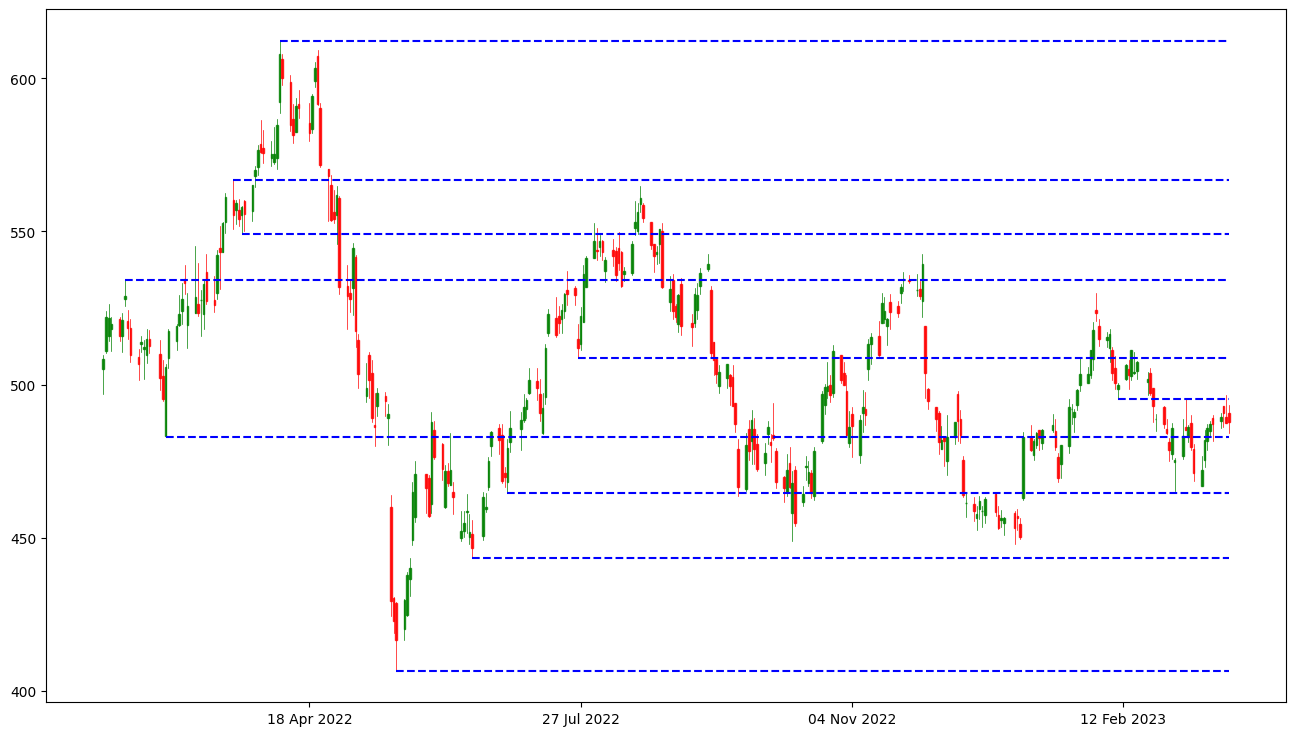

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt


# get stock prices using yfinance library
def get_stock_price(symbol):
    df = yf.download(symbol, start="2022-02-01", threads=False)
    df["Date"] = pd.to_datetime(df.index)
    df["Date"] = df["Date"].apply(mpl_dates.date2num)
    df = df.loc[:, ["Date", "Open", "High", "Low", "Close"]]
    return df


# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):
    ave = np.mean(df["High"] - df["Low"])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0


# method 2: window shifting method
# using the same symbol as the first example above
symbol = "COST"
df = get_stock_price(symbol)
pivots = []
max_list = []
min_list = []
for i in range(5, len(df) - 5):
    # taking a window of 9 candles
    high_range = df["High"][i - 5 : i + 4]
    current_max = high_range.max()
    # if we find a new maximum value, empty the max_list
    if current_max not in max_list:
        max_list = []
    max_list.append(current_max)
    # if the maximum value remains the same after shifting 5 times
    if len(max_list) == 5 and is_far_from_level(current_max, pivots, df):
        pivots.append((high_range.idxmax(), current_max))

    low_range = df["Low"][i - 5 : i + 5]
    current_min = low_range.min()
    if current_min not in min_list:
        min_list = []
    min_list.append(current_min)
    if len(min_list) == 5 and is_far_from_level(current_min, pivots, df):
        pivots.append((low_range.idxmin(), current_min))

# for visualization
def plot_all(levels, df):
    fig, ax = plt.subplots(figsize=(16, 9))
    candlestick_ohlc(
        ax, df.values, width=0.6, colorup="green", colordown="red", alpha=0.8
    )
    date_format = mpl_dates.DateFormatter("%d %b %Y")
    ax.xaxis.set_major_formatter(date_format)
    for level in levels:
        plt.hlines(
            level[1],
            xmin=df["Date"][level[0]],
            xmax=max(df["Date"]),
            colors="blue",
            linestyle="--",
        )
    fig.show()


plot_all(pivots, df)
